<a href="https://colab.research.google.com/github/salwaa-hub/jbp13_machinelearning/blob/main/jbp13_machinelearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Salwa Salsabila Daffa'atulhaq - 4.33.23.2.25

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers, models

In [3]:
# Load MNIST
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
x_train = x_train.astype("float32") / 255.
x_test = x_test.astype("float32") / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

# Add noise
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

In [4]:
# Autoencoder
input_img = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.fit(x_train_noisy, x_train,
                epochs=10,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 166s 345ms/step - loss: 0.2463 - val_loss: 0.1166
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 202s 346ms/step - loss: 0.1155 - val_loss: 0.1096
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 197s 336ms/step - loss: 0.1097 - val_loss: 0.1055
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 159s 338ms/step - loss: 0.1060 - val_loss: 0.1031
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 156s 333ms/step - loss: 0.1035 - val_loss: 0.1021
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 204s 338ms/step - loss: 0.1023 - val_loss: 0.1001
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 197s 327ms/step - loss: 0.1009 - val_loss: 0.0994
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 208s 339ms/step - loss: 0.1001 - val_loss: 0.0985
Epoch 9/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 197s 329ms/step - loss: 0.0994 - val_loss: 0.0981
Epoch 10/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 202s 329ms/step - loss: 0.0985 - val_loss: 0.0976


313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step


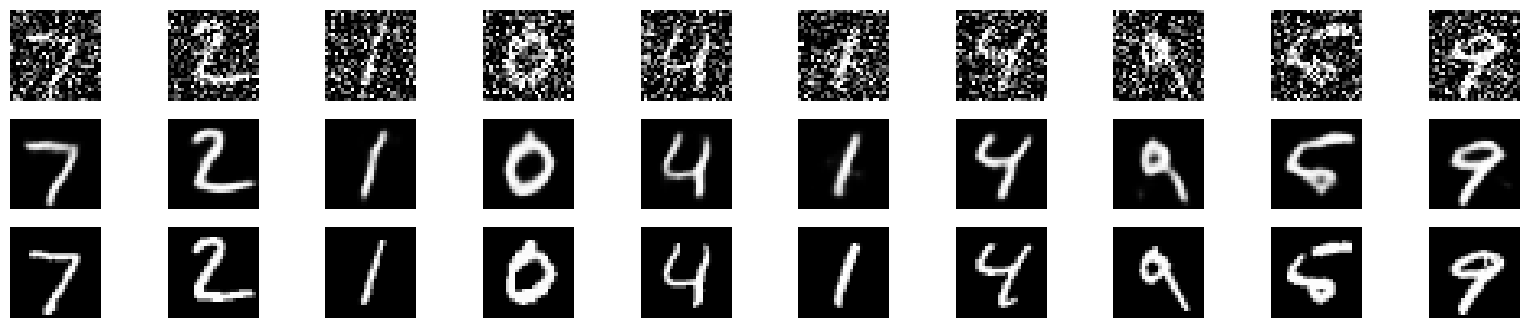

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step


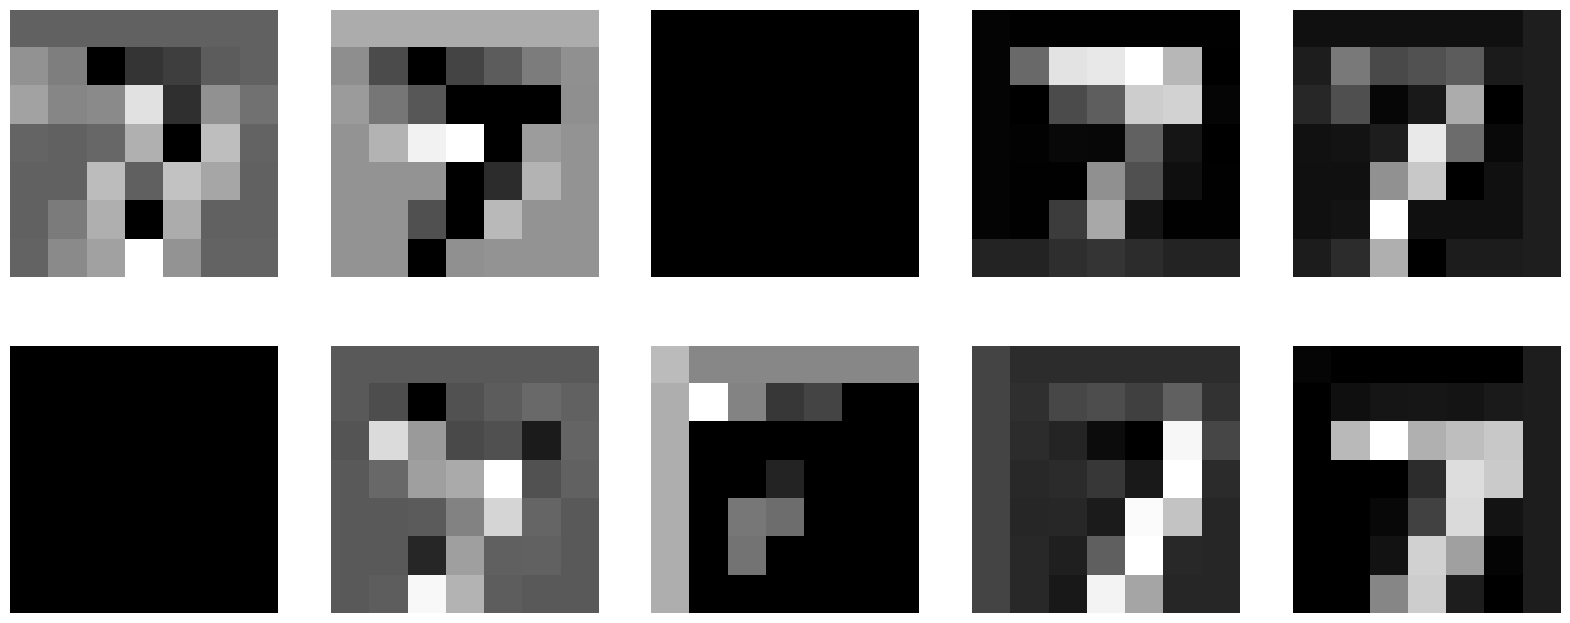

In [5]:
# Visualize reconstructions
decoded_imgs = autoencoder.predict(x_test_noisy)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.axis('off')

    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.axis('off')

    ax = plt.subplot(3, n, i + 1 + 2 * n)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.axis('off')
plt.show()

# Visualize encoding activations
encoder = keras.Model(inputs=autoencoder.input, outputs=encoded)
encoded_imgs = encoder.predict(x_test)

plt.figure(figsize=(20, 8))
for i in range(10):
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(encoded_imgs[0, :, :, i])
    plt.gray()
    ax.axis('off')
plt.show()

In [6]:
# Classification with pretraining
from tensorflow.keras.utils import to_categorical

(_, y_train), (_, y_test) = keras.datasets.mnist.load_data()
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Freeze encoder layers
for layer in encoder.layers:
    layer.trainable = False

classifier_input = keras.Input(shape=(28, 28, 1))
x = encoder(classifier_input)
x = layers.Flatten()(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dense(10, activation='softmax')(x)

model_pretrained = keras.Model(classifier_input, x)
model_pretrained.compile(optimizer='adam',
                         loss='categorical_crossentropy',
                         metrics=['accuracy'])

model_pretrained.fit(x_train[:500], y_train[:500],
                     epochs=20,
                     batch_size=64,
                     validation_data=(x_test, y_test))

score_pretrained = model_pretrained.evaluate(x_test, y_test, verbose=0)
print("Pretrained model test accuracy:", score_pretrained[1])

Epoch 1/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 821ms/step - accuracy: 0.2160 - loss: 2.2468 - val_accuracy: 0.5974 - val_loss: 1.6972
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 633ms/step - accuracy: 0.7290 - loss: 1.4408 - val_accuracy: 0.7359 - val_loss: 1.1450
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 441ms/step - accuracy: 0.8585 - loss: 0.8463 - val_accuracy: 0.7637 - val_loss: 0.8716
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 757ms/step - accuracy: 0.8578 - loss: 0.6416 - val_accuracy: 0.8118 - val_loss: 0.7048
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 636ms/step - accuracy: 0.9015 - loss: 0.4550 - val_accuracy: 0.8180 - val_loss: 0.6284
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 760ms/step - accuracy: 0.9143 - loss: 0.3725 - val_accuracy: 0.8395 - val_loss: 0.5648
Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 442ms/step - accuracy: 0.9179 - loss: 0.3409 - val_accuracy: 0.8549 - val_loss: 0.5043
Epoch 8/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 762ms/step - accuracy: 0.9225 - loss: 0.3183 - val_accuracy: 0.8523 - val_loss:

In [7]:
# Classification without pretraining (baseline)
model_baseline = keras.Sequential([
    keras.Input(shape=(28, 28, 1)),
    layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D((2,2), padding='same'),
    layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D((2,2), padding='same'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')
])

model_baseline.compile(optimizer='adam',
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])

model_baseline.fit(x_train[:500], y_train[:500],
                   epochs=20,
                   batch_size=64,
                   validation_data=(x_test, y_test))

score_baseline = model_baseline.evaluate(x_test, y_test, verbose=0)
print("Baseline model test accuracy:", score_baseline[1])

Epoch 1/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 866ms/step - accuracy: 0.2419 - loss: 2.2384 - val_accuracy: 0.3961 - val_loss: 1.9850
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 803ms/step - accuracy: 0.5653 - loss: 1.7811 - val_accuracy: 0.6742 - val_loss: 1.4018
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 803ms/step - accuracy: 0.8003 - loss: 1.0965 - val_accuracy: 0.7209 - val_loss: 0.9251
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 799ms/step - accuracy: 0.8296 - loss: 0.5962 - val_accuracy: 0.7468 - val_loss: 0.7890
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 11s 844ms/step - accuracy: 0.8273 - loss: 0.5748 - val_accuracy: 0.7900 - val_loss: 0.6651
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 502ms/step - accuracy: 0.8690 - loss: 0.3915 - val_accuracy: 0.8250 - val_loss: 0.5683
Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 841ms/step - accuracy: 0.9018 - loss: 0.3309 - val_accuracy: 0.8158 - val_loss: 0.5665
Epoch 8/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 692ms/step - accuracy: 0.9186 - loss: 0.2865 - val_accuracy: 0.8424 - val_l